# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Authors:** 

Babey, Arthur Léo Maurin

Buot De L'Epine, Matthieu Marie Emmanuel

Moufidi, Abderrazzaq

**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import cv2 as cv

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

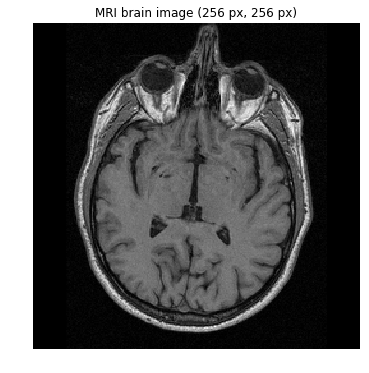

In [4]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np


# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [5]:
print('brain_im is of type {}, has dimensions {}, and a total number of {} elements'.format(
    type(brain_im), brain_im.shape, brain_im.size))

brain_im is of type <class 'numpy.ndarray'>, has dimensions (256, 256), and a total number of 65536 elements


Let's have a look on the pixels intensity histogram

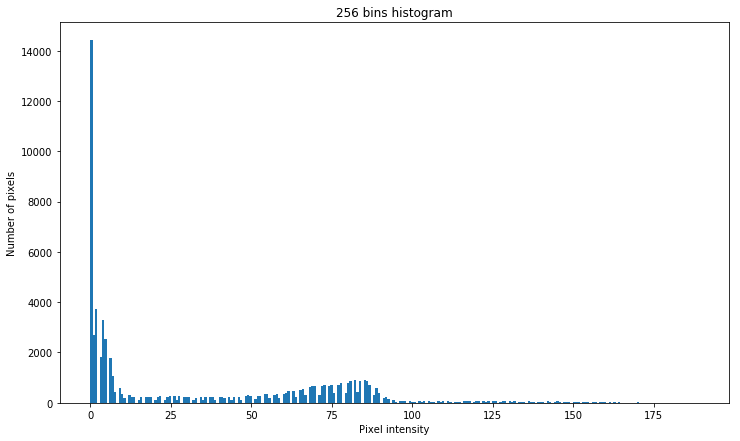

In [6]:
# Plotting of the image histogram
camera = brain_im
nb_bins = 256

plt.figure(figsize=(12, 7))
plt.hist(camera.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')

plt.show()

### 1.2 Region growing
Add your implementation and discussion

Below we implemented the region growing method which will allow us to get a region based on a chosen seed that will grow if the intensity difference with its neighbors is under a threshold.

In [7]:
import numpy as np

class Point():
    def __init__(self,x,y):
        self.x = x
        self.y = y
 
    def getX(self):
        return self.x
    def getY(self):
        return self.y
 
def getDiff(img,p1,p2):
    return abs(int(img[p1.x,p1.y]) - int(img[p2.x,p2.y]))
    #to get the intensity difference between two points
 
def getNeighbors():
    neighbors = [Point(-1, -1), Point(0, -1), Point(1, -1), Point(1, 0), Point(1, 1), \
                    Point(0, 1), Point(-1, 1), Point(-1, 0)]    
    return neighbors
    #to get the 8 neighbors from the current point
    
def regionGrowing(img,seeds,threshold):
    height, width = img.shape
    out = np.zeros(img.shape) #new binary image
    seedList = []
    for seed in seeds: #if there is more than 1 seed
        seedList.append(seed)
    label = 1
    neighbors = getNeighbors()
    
    while(len(seedList)>0):
        currentPoint = seedList.pop(0)
        out[currentPoint.x,currentPoint.y] = label
        for i in range(8): #itering on the neighbors
            x = currentPoint.x + neighbors[i].x #to get each neighbor
            y = currentPoint.y + neighbors[i].y
            
            if x < 0 or y < 0 or x >= height or y >= width: #check if the point belongs to the image
                continue
            diff = getDiff(img,currentPoint,Point(x,y))
            if diff < threshold and out[x,y] == 0: 
                out[x,y] = label
                seedList.append(Point(x,y)) #add the valid neighbors to the seed list
    size = out.sum() #size of the brain in pixel
    
    return out, size

The region growing method returns a size and a map of the region, we tried multiple parameters. Below we can see the region with three different threshold (4,5,6) and with three arbitrary seeds.

In [8]:
out4, size4 = regionGrowing(brain_im, [Point(143,80), Point(80, 143), Point(123, 110)], 4)
out5, size5 = regionGrowing(brain_im, [Point(143,80), Point(80, 143), Point(123, 110)], 5)
out6, size6 = regionGrowing(brain_im, [Point(143,80), Point(80, 143), Point(123, 110)], 6)

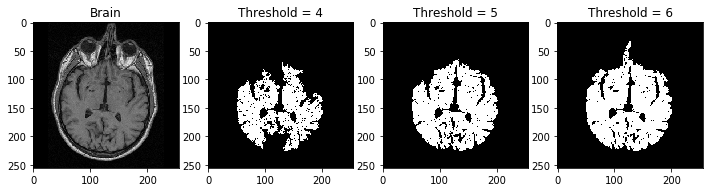

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
ax[0].set_title("Brain")
ax[0].imshow(brain_im, cmap='gray')

ax[1].set_title("Threshold = 4")
ax[1].imshow(out4, cmap='gray')

ax[2].set_title("Threshold = 5")
ax[2].imshow(out5, cmap='gray')

ax[3].set_title("Threshold = 6")
ax[3].imshow(out6, cmap='gray')

plt.show()

We can see on the plot above that the threshold of 5 is the best one since with a 6 threshold we get a region that does not belongs to the brain. With that threshold we get a brain size of 14963 pixels. The region corresponds quite good to the brain even if it's not perfect. We can see on the plot that there is multiple holes and we will try next different methods to see if we can achieve a better result.

In [11]:
print('The brain is of size {} pixels'.format(size5))

The brain is of size 14936.0 pixels


### 1.3 Contour detection
Sobel filtering allow us to extract edges from the picture. In this attempt, we first detect edges and then combine them into contours. The idea is to find two different shapes: the skull and the brain. The brain parts then correspond to the inner shape inside the skull.

Note that we used blurring and thresholding in order to improve the edge detection. And also a morphological operation to remove the smallest components.

In [12]:
from skimage.filters import sobel
import cv2 as cv
from skimage import morphology

# Blurring improves edge detection
blur_im = cv.blur(brain_im, (2, 2))

# Sobel filter for edge detection
sobel_im = sobel(blur_im)

# Thresholding to retain strongest edges
ret, thresh_im = cv.threshold(sobel_im, 0.042, 1, cv.THRESH_BINARY)

# Detecting the whole skull area
contour_im1, contours1, h = cv.findContours(thresh_im.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
result_contour1 = cv.drawContours(contour_im1, contours1, 0, (0, 255, 0))
fill_im = cv.fillPoly(thresh_im.copy(), pts=contours1, color=(255, 255, 255))

# The brain consists of the dark parts inside the skull
brain_part = (1 - thresh_im).astype(bool) & fill_im.astype(bool)
brain_part = morphology.remove_small_objects(brain_part, min_size=1000)

# Contour detection on the brain part
contour_im, contours, h = cv.findContours(brain_part.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

result_contour = cv.drawContours(contour_im, contours, 0, (0, 255, 0))
result_im = brain_im | (contour_im * 255)


fig, ax = plt.subplots(1, 4, figsize=(18, 6))
ax[0].set_title("Sobel filtering")
ax[0].imshow(thresh_im, cmap='gray')

ax[1].set_title("Skull shape")
ax[1].imshow(fill_im, cmap='gray')

ax[2].set_title("Brain shape")
ax[2].imshow(contour_im, cmap='gray')

ax[3].set_title("Resulting area (yellow)")
ax[3].imshow(result_im)

plt.show()
print('Brain contour area (in pixels):', int(cv.contourArea(contours[0])))

ValueError: not enough values to unpack (expected 3, got 2)

### 1.4 Additional method(s)
In this part, we filtered our image using Canny filter with two different sigmas.

We try to look the contours that exist in the same two filtered images, and then we select the area of the brain.

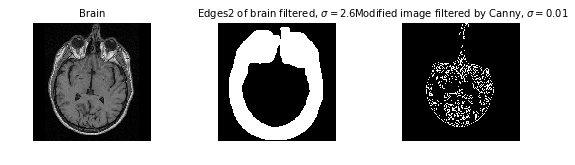

In [13]:
import cv2
from scipy import ndimage, misc
from scipy import ndimage as ndi
from skimage import data, io, filters
from skimage import feature

im=skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))


# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im, sigma=3.39)
edges2 = feature.canny(im, sigma=2.6)

edges3=edges2
## Variable of area
a=0

for x in range(len(edges1)):
    for y in range(len(edges1[0])):
        ## We look at the intersection of the two images filtered by Canny
        ## Some of pixels of edges2 were on the same contours but not in edges1, 
        ## thus we add the second condition
        if edges2[x,y]==True or np.sum(edges1[x-9:x+10,y-9:y+10])>0:
            edges2[x,y]=255
        else:
            edges2[x,y]=0
            
## Filter median to eliminate noise in edges2
edges2=ndimage.median_filter(edges2, size=5)

for x in range(len(im)):
    for y in range(len(im[0])):
        ## First condition refers to the skull part
        ## the second refers to the intensity of the background of the image source
        if edges2[x,y]==True or im[x,y]<20:
            im[x,y]=0
        else:
            a+=1

edges3=feature.canny(im, sigma=0.01)

# Display results 
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 6),
                                    sharex=True, sharey=True)

ax1.imshow(brain_im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Brain', fontsize=10)

ax2.imshow(edges2, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Edges2 of brain filtered, $\sigma=2.6$', fontsize=10)

ax3.imshow(edges3, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Modified image filtered by Canny, $\sigma=0.01$', fontsize=10)


fig.tight_layout()

plt.show()

In [14]:
print('The area of the brain is', a)

The area of the brain is 16578


## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [15]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


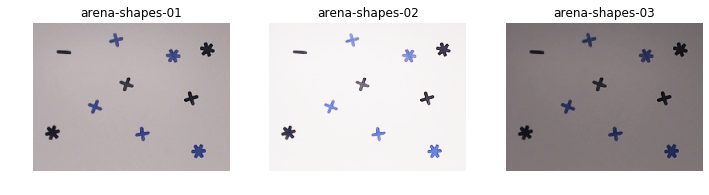

In [16]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
The challenge in this exercise is first to handle the lighting difference for all three pictures. We do this by normalizing the value in the HSV representation.
It is then pretty straightforward to do a shape detection to count the shapes and detect the different colors using hard thresholds.

In [17]:

def normalize_intensity(img):
    hsv_im = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    mean_v = hsv_im[:, :, 2].mean()
    hsv_im[:, :, 2] = hsv_im[:, :, 2] / mean_v * 200
    img = cv.cvtColor(hsv_im, cv.COLOR_HSV2RGB)
    return img

def foreground_threshold(img):
    gray_im = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    mask = cv.inRange(gray_im, 0, 150)
    
    return mask

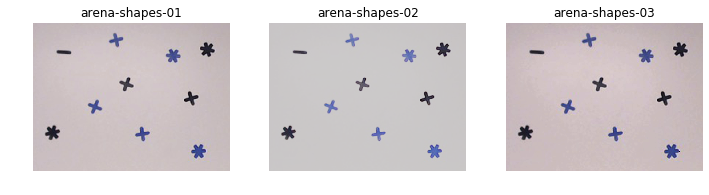

In [18]:
# Plot normalized images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    #ax.imshow(cv.cvtColor(cv.cvtColor(im, cv.COLOR_RGB2HSV), cv.COLOR_HSV2RGB))
    ax.imshow(normalize_intensity(im))
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [19]:
for ax, im, nm in zip(axes.ravel(), images, im_names):
    blue_count = 0
    black_count = 0
    im = im.copy()
    norm_im = normalize_intensity(im)
    hsv_im = cv.cvtColor(norm_im, cv.COLOR_RGB2HSV)
    thresh_im = foreground_threshold(norm_im)
    
    process_im, contours, hierarchy = cv.findContours(thresh_im.astype(np.uint8),cv.RETR_LIST,
                                                      cv.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv.contourArea(c) > 300]
    
    for i, c in enumerate(contours):
        M = cv.moments(c)
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        
        # We use the color of the middle point to get the shape color
        shape_color = norm_im[cY, cX]
        is_blue = shape_color[2] > 120
        
        if is_blue:
            blue_count += 1
        else:
            black_count += 1

    print('Number of blue shapes:', blue_count)
    print('Number of black shapes:', black_count)
    print('')

ValueError: not enough values to unpack (expected 3, got 2)

### 2.3 Total area (in pixels) of each color
In this question we have used the method thresholding.
First, we normalize our images to get the same intensity, then we plot the histogram to see where the Gaussian that have less magnitude intersected, because in these Gaussians where our shapes are, thus we neglect the location of Gaussian with high magnitude. At the end we tried to correct the threshold and see the result for each of them.

Note: the images used during the processing are BGR mode.

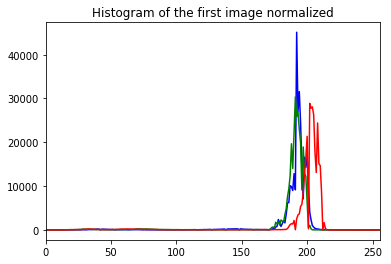

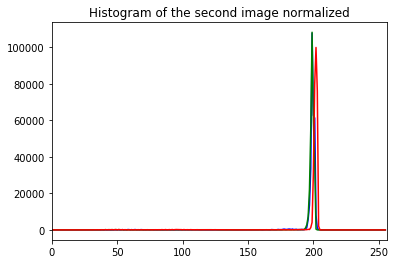

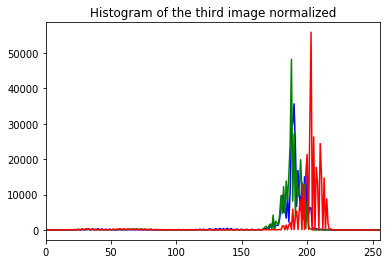

In [20]:
import numpy as np
import cv2
from skimage import data, io, filters
import matplotlib.pyplot as plt


## Opening images
img1=normalize_intensity(cv2.imread(os.path.join(data_path,'arena-shapes-01.png')))
img2=normalize_intensity(cv2.imread(os.path.join(data_path,'arena-shapes-02.png')))
img3=normalize_intensity(cv2.imread(os.path.join(data_path,'arena-shapes-03.png')))



## Image that will contain modifications
img=[img1,img2,img3]

## Filter mean
img1=cv2.medianBlur(img1, 3)
img2=cv2.medianBlur(img2, 3)
img3=cv2.medianBlur(img3, 3)

## Histogram where we extracted the threshold
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img1],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title("Histogram of the first image normalized")
plt.show()
for i,col in enumerate(color):
    histr = cv2.calcHist([img2],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title("Histogram of the second image normalized")
plt.show()
for i,col in enumerate(color):
    histr = cv2.calcHist([img3],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

plt.title("Histogram of the third image normalized")
plt.show()

In [21]:
## Variable that will contain the black area
black_area=np.array([0,0,0])
blue_area=np.array([0,0,0])

## First image
for x in range(4,len(img[0])-5):
    for y in range(4,len(img[0][0])-5):
        if img1[x,y,0]>82 and np.mean(img1[x-2:x+3,y-2:y+3,1:3])<100 and np.mean(img1[x-2:x+3,y-2:y+3,0])>75:
        ## We have two threshold found on histogram.
        ## The thirs and fourth are because We are looking for
        ## the intensity of the neighbors to distinguish blue near black shapes from 
        ## the blue that we are looking for
            img[0][x,y,0]=0
            img[0][x,y,1]=0
            img[0][x,y,2]=255
            blue_area[0]+=1
        ## Black shapes have intensity less than 100(Red green) and les than (83 blue)
        elif np.mean(img1[x,y])<=100 and img1[x,y,0]<83:
            img[0][x,y,0]=0
            img[0][x,y,2]=0
            img[0][x,y,1]=0
            black_area[0]+=1
        else:
            img[0][x,y,0]=255
            img[0][x,y,2]=255
            img[0][x,y,1]=255

## Second image
for x in range(4,len(img[1])-5):
    for y in range(4,len(img[1][0])-5):
        if img2[x,y,0]>122 and np.mean(img2[x-2:x+3,y-2:y+3,1:3])<150 and np.mean(img2[x-2:x+3,y-2:y+3,0])>160:
        ## We have two threshold found on histogram.
        ## The second one is to look the other color's intensity
        ## (the red and the green) of the neighbors to distinguish blue near black shapes from 
        ## the blue that we are looking for
            img[1][x,y,0]=0
            img[1][x,y,1]=0
            img[1][x,y,2]=255
            blue_area[1]+=1
        ## Black shapes have intensity less than 150
        elif np.mean(img2[x,y])<=150 and img2[x,y,0]<122:
            img[1][x,y,0]=0
            img[1][x,y,2]=0
            img[1][x,y,1]=0
            black_area[1]+=1
        else:
            img[1][x,y,0]=255
            img[1][x,y,2]=255
            img[1][x,y,1]=255
           
## Third image
for x in range(4,len(img[2])-5):
    for y in range(4,len(img[2][0])-5):
        if img1[x,y,0]>82 and np.mean(img1[x-2:x+3,y-2:y+3,1:3])<100 and np.mean(img1[x-2:x+3,y-2:y+3,0])>75:
        ## We have two threshold found on histogram.
        ## The thirs and fourth are because We are looking for
        ## the intensity of the neighbors to distinguish blue near black shapes from 
        ## the blue that we are looking for
            img[2][x,y,0]=0
            img[2][x,y,1]=0
            img[2][x,y,2]=255
            blue_area[2]+=1
        ## Black shapes have intensity less than 78
        elif np.mean(img1[x,y])<=100 and img1[x,y,0]<83:
            img[2][x,y,0]=0
            img[2][x,y,2]=0
            img[2][x,y,1]=0
            black_area[2]+=1
        else:
            img[2][x,y,0]=255
            img[2][x,y,2]=255
            img[2][x,y,1]=255

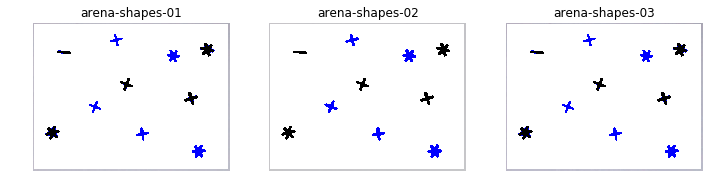

In [22]:
# Plot modified images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), img, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [23]:
print("The area of black shapes is",black_area,"\nThe area of blue shapes is",blue_area)

The area of black shapes is [4096 4095 4096] 
The area of blue shapes is [4218 4518 4218]


We can notice that the modified images are similar to the initial images with some errors in shapes as we can see above.